[*********************100%***********************]  1 of 1 completed


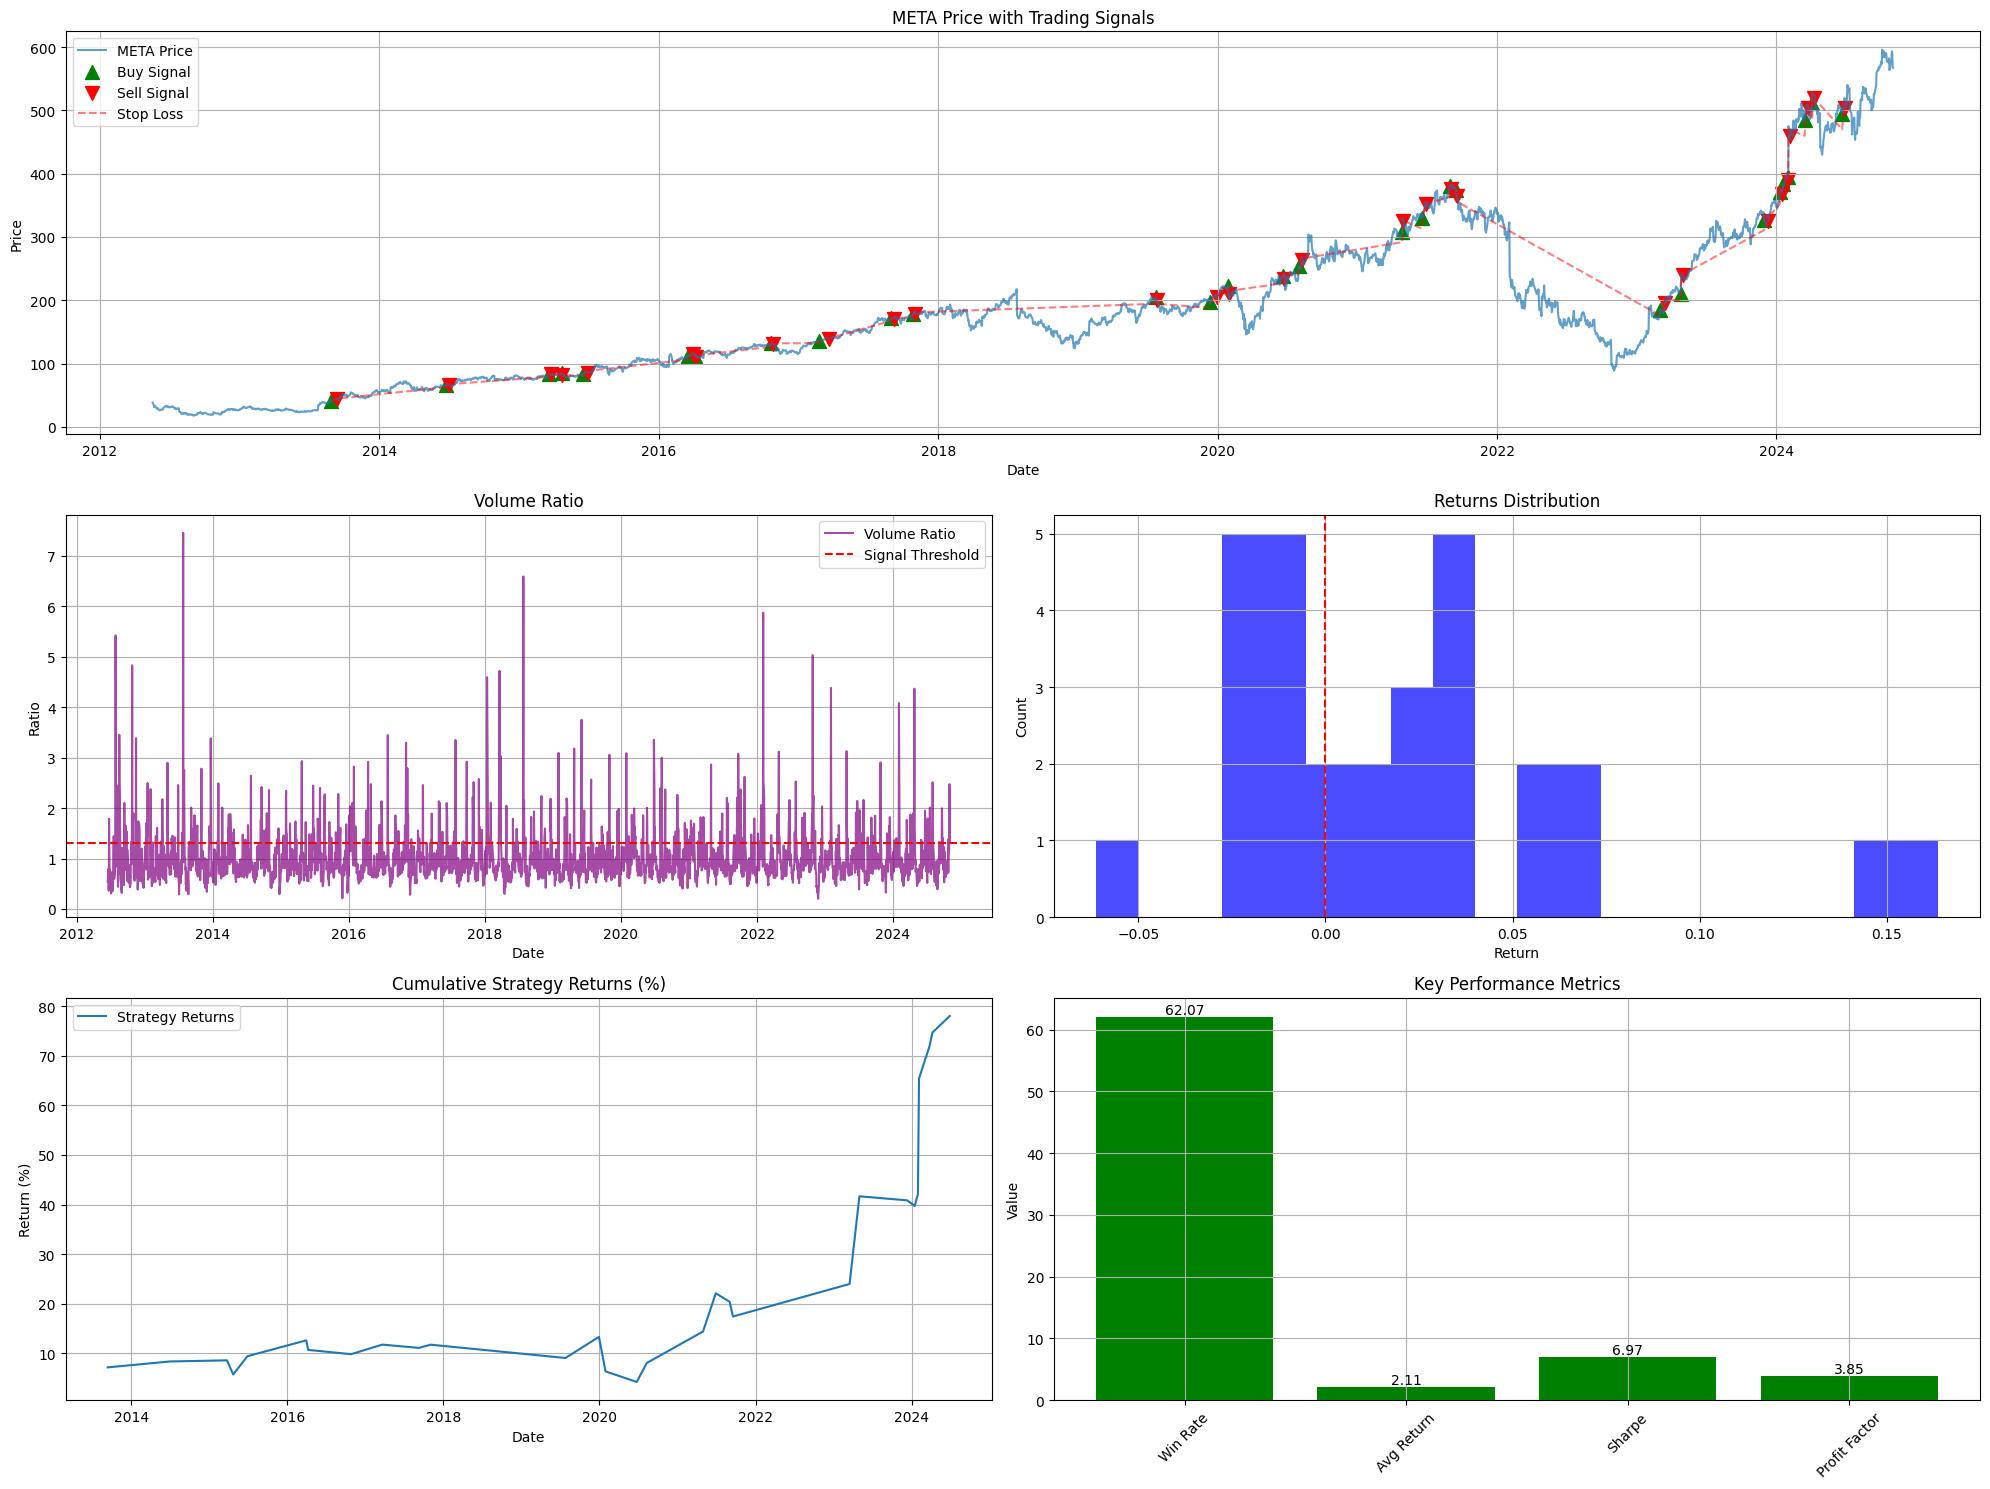


Detailed Strategy Analysis:
--------------------------------------------------
Total Trading Days: 3135
Strategy Duration: 2012-05-18 to 2024-11-01
Average Days Between Trades: 108.1

Signal Analysis:
Buy Signals: 29 (100.0%)
Sell Signals: 29 (100.0%)

Returns Analysis:
Best Trade: 16.37%
Worst Trade: -6.14%
Average Winning Trade: 4.60%
Average Losing Trade: -1.95%
Risk-Adjusted Return (Sharpe): 6.97

Risk Metrics:
Maximum Drawdown: -6.14%
Win Rate: 62.07%
Profit Factor: 3.85

Volume Analysis:
Average Volume Ratio: 1.01
Max Volume Ratio: 7.46
Volume Ratio > 2: 132 days

Monthly Performance:
Best Month: 16.37%
Worst Month: -6.14%
Average Monthly Return: 2.27%
Monthly Return Std: 4.98%
Profitable Months: 18 out of 27

Posición Actual:
--------------------------------------------------
Estado: FLAT (Sin posición)
Último precio: $567.16


<ipython-input-226-074033a675e4>:286: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  trades['YearMonth'] = trades.index.to_period('M')
<ipython-input-226-074033a675e4>:286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['YearMonth'] = trades.index.to_period('M')


In [226]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats
import matplotlib.pyplot as plt
from typing import Dict, Tuple

def calculate_var_stop(returns: pd.Series, confidence_level: float = 0.99) -> float:
    """
    Calculate Value at Risk based stop loss
    """
    if len(returns) < 2:
        return np.nan

    # Usar método paramétrico con límite máximo
    var = min(-stats.norm.ppf(1 - confidence_level) * returns.std(), 0.05)  # Max 5% VaR
    return var

def trading_strategy(data, lookback=20, vol_window=20, var_window=252):
    """
    Improved bullish strategy with proper risk management
    """
    signals = pd.DataFrame()

    # Price data
    signals['Close'] = data['Close']
    signals['High'] = data['High']
    signals['Low'] = data['Low']
    signals['Volume'] = data['Volume']

    # Technical indicators
    signals['MA20'] = signals['Close'].rolling(window=20).mean()
    signals['MA50'] = signals['Close'].rolling(window=50).mean()
    signals['MA200'] = signals['Close'].rolling(window=200).mean()

    # Volume analysis
    signals['Volume_MA20'] = signals['Volume'].rolling(window=20).mean()
    signals['Volume_Ratio'] = signals['Volume'] / signals['Volume_MA20']

    # Returns and VaR
    signals['Returns'] = signals['Close'].pct_change()
    signals['Daily_Vol'] = signals['Returns'].rolling(window=20).std()
    signals['VaR'] = signals['Returns'].rolling(window=var_window).apply(
        lambda x: calculate_var_stop(x)
    )

    # RSI
    delta = signals['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    signals['RSI'] = 100 - (100 / (1 + rs))

    # Trend strength
    signals['Trend_Strength'] = (signals['Close'] - signals['MA50']) / signals['MA50']

    # Initialize
    signals['Signal'] = 0
    signals['Position'] = 0
    signals['Stop_Loss'] = np.nan
    signals['Trade_Return'] = np.nan
    position = 0
    entry_price = 0
    highest_price = 0
    trailing_stop = 0

    # Trading logic
    for i in range(var_window + 1, len(signals)):
        current_price = signals['Close'].iloc[i]
        current_var = signals['VaR'].iloc[i]

        # Solo compramos si no estamos en posición
        if position == 0:
            # Condiciones de compra
            strong_uptrend = (
                signals['MA20'].iloc[i] > signals['MA50'].iloc[i] > signals['MA200'].iloc[i] and
                signals['Trend_Strength'].iloc[i] > 0.02  # 2% por encima de MA50
            )

            high_volume = signals['Volume_Ratio'].iloc[i] > 1.3

            rsi_ok = 30 < signals['RSI'].iloc[i] < 70

            low_volatility = signals['Daily_Vol'].iloc[i] < signals['Daily_Vol'].iloc[i-20:i].mean()

            # Señal de compra
            if strong_uptrend and high_volume and rsi_ok and low_volatility:
                position = 1
                entry_price = current_price
                highest_price = current_price

                # Initial stop loss
                var_stop = abs(current_var) if not pd.isna(current_var) else 0.02
                initial_stop = entry_price * (1 - var_stop)
                trailing_stop = initial_stop

                signals.iloc[i, signals.columns.get_loc('Signal')] = 1
                signals.iloc[i, signals.columns.get_loc('Stop_Loss')] = trailing_stop

        # Gestión de posición abierta
        elif position == 1:
            # Actualizar trailing stop si tenemos nuevo máximo
            if current_price > highest_price:
                highest_price = current_price
                trailing_stop = max(
                    trailing_stop,
                    highest_price * 0.99  # 1% trailing stop
                )
                signals.iloc[i, signals.columns.get_loc('Stop_Loss')] = trailing_stop

            # Condiciones de venta
            stop_hit = current_price < trailing_stop

            trend_broken = (
                current_price < signals['MA20'].iloc[i] and
                signals['Volume_Ratio'].iloc[i] > 1.5
            )

            if stop_hit or trend_broken:
                position = 0
                signals.iloc[i, signals.columns.get_loc('Signal')] = -1
                signals.iloc[i, signals.columns.get_loc('Trade_Return')] = current_price/entry_price - 1
                highest_price = 0
                trailing_stop = 0

        signals.iloc[i, signals.columns.get_loc('Position')] = position

    return signals

def analyze_performance(signals):
    # Filter trades with returns
    trades = signals[signals['Trade_Return'].notna()].copy()

    if len(trades) == 0:
        return {
            'Total_Trades': 0,
            'Win_Rate': 0,
            'Average_Return': 0,
            'Cumulative_Return': 0,
            'Winning_Trades': 0,
            'Losing_Trades': 0,
            'Max_Drawdown': 0,
            'Sharpe_Ratio': 0,
            'Profit_Factor': 0
        }

    total_trades = len(trades)
    winning_trades = len(trades[trades['Trade_Return'] > 0])
    losing_trades = len(trades[trades['Trade_Return'] <= 0])
    win_rate = winning_trades / total_trades if total_trades > 0 else 0

    avg_return = trades['Trade_Return'].mean()
    cumulative_return = (1 + trades['Trade_Return']).prod() - 1

    max_drawdown = trades['Trade_Return'].min()
    sharpe_ratio = np.sqrt(252) * (avg_return / trades['Trade_Return'].std()) if len(trades) > 1 else 0

    profit_factor = abs(trades[trades['Trade_Return'] > 0]['Trade_Return'].sum() /
                       trades[trades['Trade_Return'] < 0]['Trade_Return'].sum()) if len(trades[trades['Trade_Return'] < 0]) > 0 else np.inf

    return {
        'Total_Trades': total_trades,
        'Win_Rate': win_rate,
        'Average_Return': avg_return,
        'Cumulative_Return': cumulative_return,
        'Winning_Trades': winning_trades,
        'Losing_Trades': losing_trades,
        'Max_Drawdown': max_drawdown,
        'Sharpe_Ratio': sharpe_ratio,
        'Profit_Factor': profit_factor
    }

def plot_trading_results(signals: pd.DataFrame, performance: Dict) -> None:
    # Crear una figura con subplots
    fig = plt.figure(figsize=(20, 15))

    # 1. Precio y señales
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax1.plot(signals.index, signals['Close'], label='META Price', alpha=0.7)

    # Plotear señales de compra y venta
    buy_signals = signals[signals['Signal'] == 1]
    sell_signals = signals[signals['Signal'] == -1]

    ax1.scatter(buy_signals.index, buy_signals['Close'],
                marker='^', color='green', s=100, label='Buy Signal')
    ax1.scatter(sell_signals.index, sell_signals['Close'],
                marker='v', color='red', s=100, label='Sell Signal')

    # Plotear stop loss
    signals_with_stops = signals[signals['Stop_Loss'].notna()]
    ax1.plot(signals_with_stops.index, signals_with_stops['Stop_Loss'],
             'r--', label='Stop Loss', alpha=0.5)

    ax1.set_title('META Price with Trading Signals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)

    # 2. Volume Ratio
    ax2 = plt.subplot2grid((3, 2), (1, 0))
    ax2.plot(signals.index, signals['Volume_Ratio'], label='Volume Ratio', color='purple', alpha=0.7)
    ax2.axhline(y=1.3, color='r', linestyle='--', label='Signal Threshold')
    ax2.set_title('Volume Ratio')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Ratio')
    ax2.legend()
    ax2.grid(True)

    # 3. Returns Distribution
    ax3 = plt.subplot2grid((3, 2), (1, 1))
    trades = signals[signals['Trade_Return'].notna()]

    ax3.hist(trades['Trade_Return'], bins=20, alpha=0.7, color='blue')
    ax3.axvline(x=0, color='r', linestyle='--')
    ax3.set_title('Returns Distribution')
    ax3.set_xlabel('Return')
    ax3.set_ylabel('Count')
    ax3.grid(True)

    # 4. Cumulative Returns
    ax4 = plt.subplot2grid((3, 2), (2, 0))
    cumulative_returns = (1 + trades['Trade_Return']).cumprod() - 1
    ax4.plot(cumulative_returns.index, cumulative_returns * 100, label='Strategy Returns')
    ax4.set_title('Cumulative Strategy Returns (%)')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Return (%)')
    ax4.legend()
    ax4.grid(True)

    # 5. Performance Metrics
    ax5 = plt.subplot2grid((3, 2), (2, 1))
    metrics = {
        'Win Rate': performance['Win_Rate'] * 100,
        'Avg Return': performance['Average_Return'] * 100,
        'Sharpe': performance['Sharpe_Ratio'],
        'Profit Factor': performance['Profit_Factor']
    }

    colors = ['green' if v > 0 else 'red' for v in metrics.values()]
    bars = ax5.bar(metrics.keys(), metrics.values(), color=colors)
    ax5.set_title('Key Performance Metrics')
    ax5.set_ylabel('Value')
    # Añadir valores encima de las barras
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
    plt.xticks(rotation=45)
    ax5.grid(True)

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\nDetailed Strategy Analysis:")
    print("-" * 50)
    print(f"Total Trading Days: {len(signals)}")
    print(f"Strategy Duration: {signals.index[0].strftime('%Y-%m-%d')} to {signals.index[-1].strftime('%Y-%m-%d')}")
    print(f"Average Days Between Trades: {len(signals) / performance['Total_Trades']:.1f}")

    print("\nSignal Analysis:")
    print(f"Buy Signals: {len(signals[signals['Signal'] == 1])} ({len(signals[signals['Signal'] == 1])/performance['Total_Trades']*100:.1f}%)")
    print(f"Sell Signals: {len(signals[signals['Signal'] == -1])} ({len(signals[signals['Signal'] == -1])/performance['Total_Trades']*100:.1f}%)")

    print("\nReturns Analysis:")
    print(f"Best Trade: {trades['Trade_Return'].max()*100:.2f}%")
    print(f"Worst Trade: {trades['Trade_Return'].min()*100:.2f}%")
    print(f"Average Winning Trade: {trades[trades['Trade_Return'] > 0]['Trade_Return'].mean()*100:.2f}%")
    print(f"Average Losing Trade: {trades[trades['Trade_Return'] < 0]['Trade_Return'].mean()*100:.2f}%")
    print(f"Risk-Adjusted Return (Sharpe): {performance['Sharpe_Ratio']:.2f}")

    print("\nRisk Metrics:")
    print(f"Maximum Drawdown: {performance['Max_Drawdown']*100:.2f}%")
    print(f"Win Rate: {performance['Win_Rate']*100:.2f}%")
    print(f"Profit Factor: {performance['Profit_Factor']:.2f}")

    print("\nVolume Analysis:")
    print(f"Average Volume Ratio: {signals['Volume_Ratio'].mean():.2f}")
    print(f"Max Volume Ratio: {signals['Volume_Ratio'].max():.2f}")
    print(f"Volume Ratio > 2: {len(signals[signals['Volume_Ratio'] > 2])} days")

    # Calculate monthly returns
    trades['YearMonth'] = trades.index.to_period('M')
    monthly_returns = trades.groupby('YearMonth')['Trade_Return'].sum()

    print("\nMonthly Performance:")
    print(f"Best Month: {monthly_returns.max()*100:.2f}%")
    print(f"Worst Month: {monthly_returns.min()*100:.2f}%")
    print(f"Average Monthly Return: {monthly_returns.mean()*100:.2f}%")
    print(f"Monthly Return Std: {monthly_returns.std()*100:.2f}%")
    print(f"Profitable Months: {len(monthly_returns[monthly_returns > 0])} out of {len(monthly_returns)}")

def get_meta_data(start_date='2010-01-01', end_date='2024-12-31'):
    try:
        meta = yf.download('META', start=start_date, end=end_date)
        return meta
    except Exception as e:
        print(f"Error downloading META data: {e}")
        raise

def print_current_position(signals: pd.DataFrame) -> None:
    """
    Imprime la información de la última posición si existe
    """
    last_position = signals['Position'].iloc[-1]
    last_row = signals.iloc[-1]

    print("\nPosición Actual:")
    print("-" * 50)

    if last_position == 1:
        # Encontrar el precio de entrada de la posición actual
        entry_idx = signals[signals['Signal'] == 1].index[-1]
        entry_price = signals.loc[entry_idx, 'Close']

        current_price = last_row['Close']
        stop_loss = last_row['Stop_Loss']

        risk = abs(current_price - stop_loss) / current_price * 100
        gain = (current_price - entry_price) / entry_price * 100

        print(f"Estado: LONG")
        print(f"Precio de entrada: ${entry_price:.2f}")
        print(f"Precio actual: ${current_price:.2f}")
        print(f"Stop Loss: ${stop_loss:.2f}")
        print(f"Ganancia actual: {gain:.2f}%")
        print(f"Riesgo actual: {risk:.2f}%")
    else:
        print("Estado: FLAT (Sin posición)")
        print(f"Último precio: ${last_row['Close']:.2f}")

def run_analysis():
    # Get data and run strategy
    data = get_meta_data()
    results = trading_strategy(data)
    performance = analyze_performance(results)

    # Plot and analyze results
    plot_trading_results(results, performance)

    # Mostrar posición actual
    print_current_position(results)

    return results, performance

if __name__ == "__main__":
    results, performance = run_analysis()